# Map rotation

The surface of the star is based on an [HEALPix](https://healpix.jpl.nasa.gov/) map, that we need to rotate in order to simulate the star's rotation

In [2]:
import jax
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from spotter.experimental.core import spots
from spotter import uniform

N = 2**6
u = (0.1, 0.2)
np.random.seed(42)
radius = np.random.uniform(0.01, 0.2, size=30)
x = 1 - jax.vmap(spots, in_axes=(None, 0, 0, None))(N, *uniform(30), radius)[-1] * 0.3

# limb darkening is only applied on disk so no point
# to show it here in this Mollewide projection
hp.mollview(x, cmap="magma", min=0, max=1)

TypeError: lt got incompatible shapes for broadcasting: (49152,), (30,).

In [8]:
np.array(uniform(30)).T[0]

array([1.86299108, 2.43894358])

In [9]:
radius

array([0.08116262, 0.19063572, 0.14907885, 0.12374511, 0.03964354,
       0.03963896, 0.02103589, 0.17457347, 0.12421185, 0.14453379,
       0.01391105, 0.19428287, 0.1681641 , 0.05034443, 0.04454674,
       0.04484686, 0.06780603, 0.10970372, 0.09206955, 0.06533354,
       0.12625205, 0.03650383, 0.06550748, 0.07960875, 0.0966533 ,
       0.15918343, 0.04793802, 0.10770454, 0.12255877, 0.01882558])

In [7]:
spots(N, *np.array(uniform(30)).T[0], radius)

TypeError: lt got incompatible shapes for broadcasting: (49152,), (30,).

In [3]:
jax.vmap(spots, in_axes=(None, 0, 0, None))(N, *uniform(30), radius)

TypeError: lt got incompatible shapes for broadcasting: (49152,), (30,).

One way to perform the rotation is to use the `Rotation` object (and to project the result on a disk before multiplying it by the limb darkening law)

In [2]:
rotated_pixels = hp.Rotator(rot=np.pi / 4, deg=False).rotate_map_pixel(x)

But if we have to do that for say 1000 phases to compute the rotational light curve of the star (the disk-integrated flux) it can be very slow.

In [3]:
from time import time

phase = np.linspace(0, 2 * np.pi, 1000)

t0 = time()
for i in phase:
    rotated_pixels = hp.Rotator(rot=i, deg=False).rotate_map_pixel(x)
    flux = np.sum(rotated_pixels)
print(f"{time() - t0:.5f} s")

8.25880 s


So the idea is, instead of rotating the map, to rotate the point of view within the healpix sphere, compute a mask of the stellar disk being rotated, and compute the flux. This is illustrated below and implemented in the `Star` object.

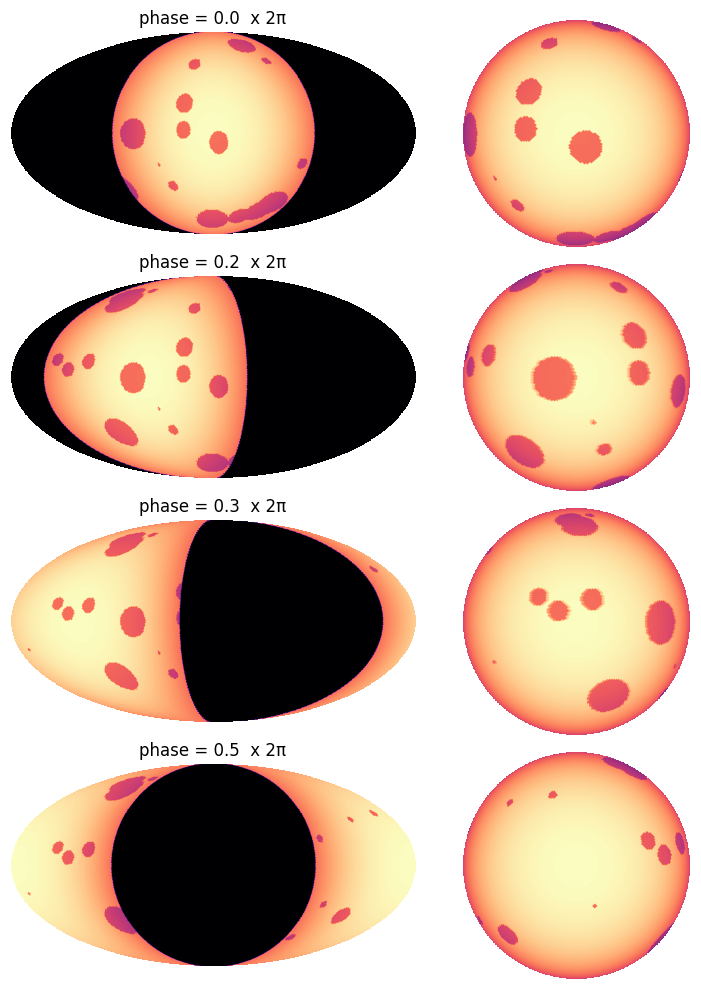

In [4]:
import jax

fig, axes = plt.subplots(4, 2, figsize=(8, 10))

# notice how we can compute maps all at once
# thanks to jax
phis = np.linspace(0, np.pi, 4)
maps = jax.vmap(star.limbed, in_axes=(None, None, 0))(x, u, phis)

for i, m in enumerate(maps):
    ax = axes[i, 0]
    img = hp.mollview(m, return_projected_map=True)
    plt.close()
    ax.imshow(img, cmap="magma", vmin=0, vmax=1, origin="lower")
    ax.set_title(f"phase = {phis[i]/2/np.pi:.1f}  x 2π")
    ax.axis("off")

    ax = axes[i, 1]
    star.show(m, u, ax=ax, vmin=0, vmax=1, phase=phis[i])

plt.tight_layout()

```{note}
The smooth edges around the spots of the projected disk (right plots) are due to interpolation when applying the healpy `Rotator` object. This is only present when the map is shown with `Star.show` as the `Rotator` object is not the way the flux is computed.
```

Let's make a small benchmark using the map above

In [5]:
from time import time

# compilation
f = jax.jit(jax.vmap(star.flux, in_axes=(None, None, 0)))
jax.block_until_ready(f(x, u, phase))

t0 = time()
jax.block_until_ready(f(x, u, phase))
print(f"{time() - t0:.5f} s")

0.08436 s
